In [30]:
# calculate annual total fossil fuel emission for 
# ODIAC and EDGAR5
# and compare

In [31]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [32]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import regionmask
from util.functions import area_latlon
from util.gamap_colormap import WhGrYlRd

In [58]:
# GEOS-Chem default ffCO2 emission file
gc_input_dir = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2019-12/'
ds_gc = xr.open_dataset(gc_input_dir + 'ODIAC_CO2.monthly.generic.1x1.nc')
ds_gc

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 180)
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2014-12-01
Data variables:
    CO2      (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.5.6 (http://code.zmaw.de/p...
    Conventions:  COARDS
    Title:        COARDS/netCDF file created by BPCH2COARDS (GAMAP v2-03+)
    Model:        GENERIC
    Delta_Lon:    1.0
    Delta_Lat:    1.0
    NLayers:      1
    Start_Date:   20000101
    Start_Time:   0
    End_Date:     20141201
    End_Time:     0
    Delta_Time:   0
    CDO:          Climate Data Operators version 1.5.6.1 (http://code.zmaw.de...
    history:      Fri Apr 17 10:56:08 2015: ncatted -a axis,time,o,c,T ODIAC_...

In [33]:
# compute total ffCO2 emissions with available years of data
first_yr = 1990
last_yr  = 2018
eu28_names = ['United Kingdom', 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']
eu28_tmp = np.zeros(len(eu28_names))

In [34]:
# EDGAR
input_dir = '/exports/csce/datastore/geos/users/msadiq/'
year_vec_edgar = np.arange(first_yr, last_yr+1,1) #[2016,2017,2018]
lat_res = 0.1
lon_res = 0.1
varname = 'emi_co2'
fname1 = 'EDGARv5/v50_CO2_excl_short-cycle_org_C_'
fname2 = '.0.1x0.1.nc'
sum_edgar_global = np.zeros(len(year_vec))
sum_edgar_eu28 = np.zeros(len(year_vec))

In [35]:
tmp = xr.open_dataset(input_dir+'EDGARv5/v50_CO2_excl_short-cycle_org_C_2016.0.1x0.1.nc')
dr = tmp['emi_co2']       #.attrs#['global_total'] #['intl_bunker'][:,:,1].plot()
# create country masks
mask = regionmask.defined_regions.natural_earth.countries_110.mask(dr)

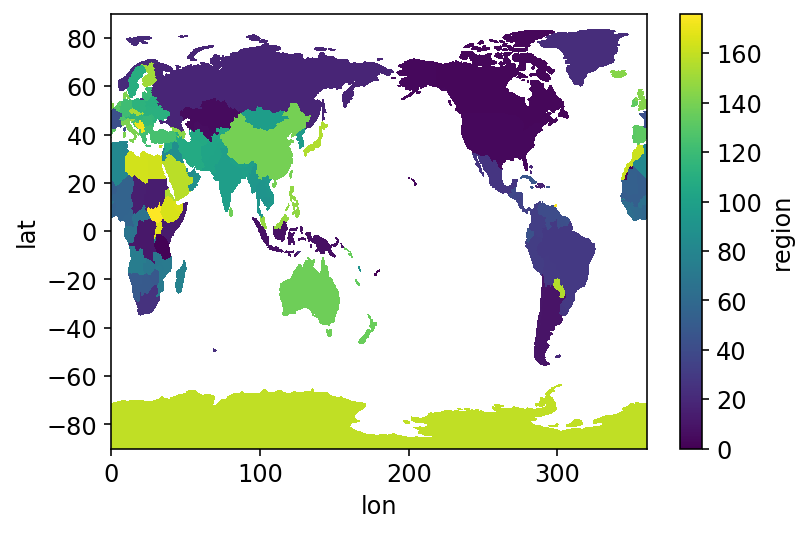

In [36]:
mask.plot()
mean_countries = dr.groupby(mask).mean('stacked_lat_lon')
names = regionmask.defined_regions.natural_earth.countries_110[mean_countries.region.values].names
mean_countries.coords['names'] = ('region', names)

In [37]:
mean_countries.names.values

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "CÃ´te d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', '

In [38]:
for i, iyear in enumerate(year_vec):
    ds_EDGAR = xr.open_dataset(input_dir + 
                               fname1 +
                               str(iyear) + 
                               fname2)
    data = ds_EDGAR[varname].copy()
    
    for ilat, lat in enumerate(data.lat):
        area_tmp = area_latlon(lat1 = lat, 
                               lon1 = data.lon[10].values, 
                               lat2 = lat + lat_res, 
                               lon2 = data.lon[10].values + lon_res)
        if(iyear == 2016):
            data[ilat,:] = data[ilat,:] * area_tmp *3600*24*366*1e6 # unit: kgCO2/yr
        else:
            data[ilat,:] = data[ilat,:] * area_tmp *3600*24*365*1e6 # unit: kgCO2/yr
    annual_edgar = data.copy()
    total_edgar = data.sum()   # kgCO2/year, same as data description
    ann_total = total_edgar.values*1e-12        # GtCO2/yr
    ann_total_C = total_edgar.values*1e-12*12/44  # GtC/yr
    
    sum_countries = annual_edgar.groupby(mask).sum('stacked_lat_lon')
    sum_countries.coords['names'] = ('region', names)
    
    eu28_tmp = np.zeros(len(eu28_names))
    for count, name in enumerate(eu28_names):
        #print(sum_countries.isel(region=(sum_countries.names == eu28_names[count])))
        eu28_tmp[count] = sum_countries.isel(region=(sum_countries.names == eu28_names[count]))
    
    sum_edgar_eu28[i] = sum(eu28_tmp)*1e-12 # GtCO2/yr
    print(str(iyear), ' EU28 annual emission: ' + str(sum_edgar_eu28[i]))
    
    sum_edgar_global[i] = ann_total
    print(str(iyear), ' global annual emission: ' + str(sum_edgar_global[i]))
    

1990  EU28 annual emission: 4.309843280128
1990  global annual emission: 22.62063644672
1991  EU28 annual emission: 4.2588433264639995
1991  global annual emission: 22.737984684032
1992  EU28 annual emission: 4.096181457408
1992  global annual emission: 22.606619082752
1993  EU28 annual emission: 4.026770161152
1993  global annual emission: 22.767713910784
1994  EU28 annual emission: 4.007972875776
1994  global annual emission: 22.98852933632
1995  EU28 annual emission: 4.052490051072
1995  global annual emission: 23.640011702271998
1996  EU28 annual emission: 4.151868289024
1996  global annual emission: 24.040458682367998
1997  EU28 annual emission: 4.078482040832
1997  global annual emission: 24.441899712512
1998  EU28 annual emission: 4.072385868288
1998  global annual emission: 24.528988143616
1999  EU28 annual emission: 4.008809642496
1999  global annual emission: 24.726927835136
2000  EU28 annual emission: 4.022251607552
2000  global annual emission: 25.514106421247998
2001  EU28

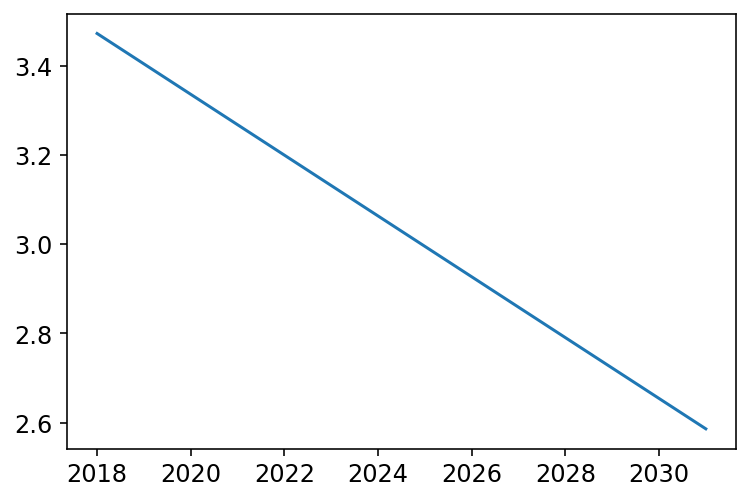

In [39]:
after_year_vector = [2018,2031]
after_2018 = np.empty(len(after_year_vector))
after_2018[0] = sum_edgar_eu28[-1]
after_2018[1] = sum_edgar_eu28[0]*0.6
plt.plot(after_year_vector, after_2018)

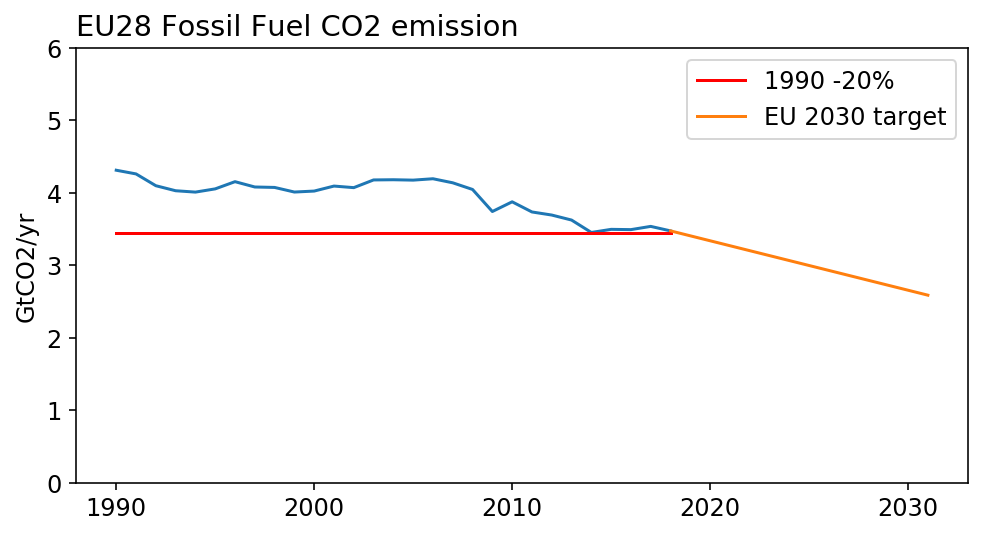

In [40]:
#plt.plot(year_vec, output_edgar)
fig = plt.figure(figsize=[8, 4])
plt.plot(year_vec_edgar, sum_edgar_eu28)

plt.title('EU28 Fossil Fuel CO2 emission', loc='left')
plt.plot(year_vec_edgar, np.repeat(sum_edgar_eu28[0]*0.8,len(sum_edgar_eu28)), 'r', label = '1990 -20%')
#plt.plot(year_vec, np.repeat(sum_edgar_eu28[0]*0.6,len(sum_edgar_eu28)), 'r', label = '1990 -40%')
plt.plot(after_year_vector, after_2018, label = 'EU 2030 target')
plt.ylim(0,6)
plt.ylabel('GtCO2/yr')
plt.legend()

#fig.tight_layout()
fig.savefig('/geos/u73/msadiq/co2_data/extract/plots/eu2020_2030.png', dpi=300)

In [93]:
# ODIAC
input_dir = '/exports/csce/datastore/geos/users/msadiq/'
first_year = 2000
last_year = 2018
year_vec_odiac = np.arange(first_year, last_year+1, 1)
lat_res = 1.
lon_res = 1.
varname1 = 'land'
varname2 = 'intl_bunker'
fname1 = 'odiac/odiac2019_1x1d_'
fname2 = '.nc'
sum_odiac_global = np.zeros(len(year_vec_odiac))

In [47]:
tmp = xr.open_dataset(input_dir+'odiac/odiac2019_1x1d_2016.nc')
tmp['land'] #.attrs#['global_total'] #['intl_bunker'][:,:,1].plot()

<xarray.DataArray 'land' (month: 12, lat: 180, lon: 360)>
[777600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:       gC/m2/d
    long_name:   ffco2_emission
    definition:  CO2 emissions from fossil fuel combustion, cememt production...

In [102]:
# output these emissions to match GEOS-Chem emission format
date_gc = np.repeat(np.datetime64('2000-01-01', 'ns'), 12*len(year_vec_odiac))
tmp = np.arange('2000', '2019', dtype='datetime64[M]')

for i,idate in enumerate(tmp): 
    tmp1 = str(idate) + '-01'
    date_gc[i] = np.datetime64(tmp1, 'ns')
time = date_gc
foo = xr.DataArray(0., coords=[time, ds_gc.lat, ds_gc.lon], dims=['time', 'lat', 'lon'])
target = foo.to_dataset(name = 'CO2')

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 228)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2018-12-01
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    CO2      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [103]:
for i,iyear in enumerate(year_vec_odiac):
    ds_data = xr.open_dataset(input_dir + 
                               fname1 +
                               str(iyear) + 
                               fname2)
    data = ds_data[varname1] + ds_data[varname2]
    foo[i*12:(i+1)*12,:,:] = data/(24*3600*1000) *44/12 # to kgCO2/m2/s
    if(iyear == 2016):
        days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]
    else:
        days_in_month = [31,29,31,30,31,30,31,31,30,31,30,31]

    for ilat, lat in enumerate(data.lat):
        for imonth in range(12):
            area_tmp = area_latlon(lat1 = lat, 
                                   lon1 = data.lon[10].values, 
                                   lat2 = lat + lat_res, 
                                   lon2 = data.lon[10].values + lon_res)
            data[imonth, ilat,:] = data[imonth, ilat,:] * area_tmp * days_in_month[imonth] *1e-3 # unit: kgCO2/month
    annual = data.copy()
    total = data.sum()             # kgCO2/year, same as data description
    ann_total = total.values*1e-6*44/12  # GtCO2/yr
    
    sum_odiac_global[i] = ann_total
    print(str(iyear), ' global annual emission: ' + str(sum_odiac_global[i]))


2000  global annual emission: 24.698303666666664
2001  global annual emission: 24.918393499999997
2002  global annual emission: 25.524124999999998
2003  global annual emission: 26.934138
2004  global annual emission: 28.09028933333333
2005  global annual emission: 29.315619666666667
2006  global annual emission: 30.314751499999996
2007  global annual emission: 30.83366
2008  global annual emission: 31.824250333333328
2009  global annual emission: 31.07664633333333
2010  global annual emission: 33.232070666666665
2011  global annual emission: 34.323138666666665
2012  global annual emission: 34.989118999999995
2013  global annual emission: 35.523081
2014  global annual emission: 35.619917666666666
2015  global annual emission: 35.756259
2016  global annual emission: 35.77822233333333
2017  global annual emission: 36.019188333333325
2018  global annual emission: 36.47463966666666


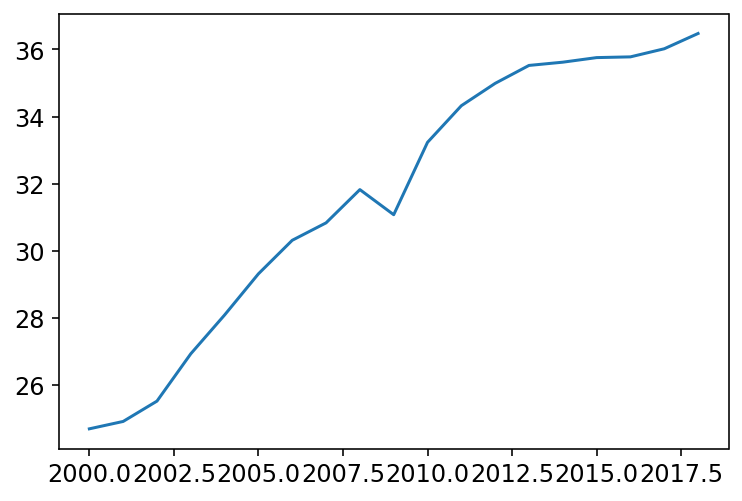

In [49]:
plt.plot(year_vec_odiac, sum_odiac_global)

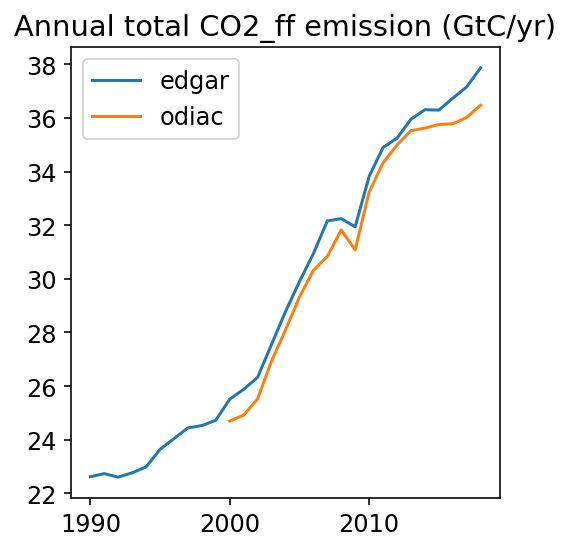

In [52]:
#bar_pos = np.arange(len(year_vec)) + 1 # position of the bars

fig = plt.figure(figsize=[4, 4])
width = 0.3

plt.plot(year_vec_edgar, sum_edgar_global, label = 'edgar')
plt.plot(year_vec_odiac, sum_odiac_global, label = 'odiac')
#bars_ODIAC = plt.bar(bar_pos-0.15, sum_odiac_global, width=width, color = 'r', label='ODIAC')
#bars_EDGAR = plt.bar(bar_pos+0.15, sum_edgar_global, width=width, color = 'b', label='EDGAR')
#plt.xticks(bar_pos, year_vec)
#plt.ylim(top = 15)
plt.title('Annual total CO2_ff emission (GtC/yr)', loc='center')
plt.legend()

fig.tight_layout()

fig.savefig('/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/annual_total_longest.png', dpi=300)

In [53]:
fig = plt.figure(figsize=[6, 4])
x = range(3)

plt.bar(x, 100*(output_edgar-output_odiac)/output_odiac, label = 'EDGAR-ODIAC')
plt.xticks(x, year_vec)

plt.title('EDGAR - ODIAC (%)')

fig.tight_layout()

NameError: name 'output_edgar' is not defined

<Figure size 432x288 with 0 Axes>